Nonlinear Regression, Part 1
=========================

<div class="overview-this-is-a-title overview">
<p class="overview-title">Overview</p>
<p>Questions</p>
    <ul>
        <li>How can I analyze enzyme kinetics data in Python?</li>
        <li>What is the process for non-linear least squares curve fitting in Python?</li>
    </ul>
<p>Objectives:</p>
    <ul>
        <li> Create a pandas dataframe with enzyme kinetics data from a .csv file</li>
        <li> Add velocity calculations to the dataframe</li>
        <li> Perform the non-linear regression calculations</li>
    </ul>
    
<p>In this module, we will calculate initial rates from the raw data (&Delta;A<sub>405</sub>) in an enzyme kinetics experiment with alkaline phosphatase. In the process, we will import the raw data into a pandas dataframe, use some pandas tools to reorganize the data, produce a second pandas dataframe that contains the substrate concentrations and initial rates at each concentration. Finally, we will export this information to a csv file to use in the next module, where you will explore nonlinear curve fitting in python.
    </p>
</div>

## Importing the Data
We start by importing data from a csv file as we did earlier with the data for linear regression. These data represent the rate of p-nitrophenol appearance for a series of p-nitrophenol phosphate concentrations in the presence of alkaline phosphatase. We will import the libraries we need, import the data and set up a pandas dataframe.

In [1]:
# import the libraries we need
import os # to create a filehandle for the .csv file
import pandas as pd # for importing the .csv file and creating a dataframe
from scipy import stats # for performing non-linear regression

In [2]:
# Create the filehandle for the csv file that contains your data
datafile = os.path.join('data', 'AP_kin.csv') # filehandle created
print(datafile)  # filehandle confirmed

data/AP_kin.csv


## Creating the pandas dataframe
The filehandle, `datafile`, points to a csv file that contains the raw kinetics data. As we saw in the `Working with Pandas` module, the pandas library has a tool for creating a dataframe from an existing csv file. Notice that the variable for the dataframe is called AP_kin_df. The `_df` at the end of the variable name is a reminder that this is a pandas dataframe.

In [3]:
# Creating the pandas dataframe using read_csv
AP_kin_df = pd.read_csv(datafile)
AP_kin_df.head()  # looking at the first five rows of the dataframe 

,Time (min),20.0,10.0,7.0,4.0,2.0,1.0,0.7,0.4,0.2,0.1,0.05
0,0.25,0.127118,0.121434,0.123059,0.103351,0.088046,0.062613,0.051681,0.034661,0.019578,0.020353,0.005635
1,0.50,0.269802,0.257587,0.239086,0.210920,0.177801,0.122747,0.104366,0.068643,0.040318,0.040318,0.011162
2,0.75,0.373572,0.364301,0.369177,0.313216,0.246186,0.193419,0.147517,0.099906,0.059896,0.056988,0.016580
3,1.00,0.518850,0.500455,0.468796,0.400747,0.352183,0.257892,0.194682,0.134567,0.073658,0.075985,0.022757
4,1.25,0.616135,0.613302,0.556695,0.500934,0.444503,0.309966,0.258405,0.173306,0.099827,0.100796,0.027092


When you look at this dataframe, notice that the index (the item at the far left of each row) is an integer. In this case, we want to use the 'Time (min)' values that are found in the first series as the index. There is a simple fix - the set_index function. 

```python
AP_kin_df.set_index('Time (min)', inplace=True)
```

By making the time values the index for each row, we can easily omit them from our initial rate calculations. We use the `inplace=True` option to make the change to the dataframe permanent.

In [4]:
AP_kin_df.set_index('Time (min)', inplace=True)
AP_kin_df.head()

,20.0,10.0,7.0,4.0,2.0,1.0,0.7,0.4,0.2,0.1,0.05
Time (min),,,,,,,,,,,
0.25,0.127118,0.121434,0.123059,0.103351,0.088046,0.062613,0.051681,0.034661,0.019578,0.020353,0.005635
0.50,0.269802,0.257587,0.239086,0.210920,0.177801,0.122747,0.104366,0.068643,0.040318,0.040318,0.011162
0.75,0.373572,0.364301,0.369177,0.313216,0.246186,0.193419,0.147517,0.099906,0.059896,0.056988,0.016580
1.00,0.518850,0.500455,0.468796,0.400747,0.352183,0.257892,0.194682,0.134567,0.073658,0.075985,0.022757
1.25,0.616135,0.613302,0.556695,0.500934,0.444503,0.309966,0.258405,0.173306,0.099827,0.100796,0.027092


## Datatype
Before we calculate the slopes to get initial velocities, we need to check for the datatypes on the numbers. We must ensure that the numbers are floats, rather than strings, so we can do calculations on them.

In [5]:
AP_kin_df.index.dtype # checking to see if the numbers are strings or floats

dtype('float64')

## Calculating the initial velocity
The index for each row is the time, which will be the x values to get the slope of each line. The values in each column are the absorbance values at each time point, so those will be our y values. Now we need to follow these steps to calculate the initial velocity at each substrate concentration. 
1. Inspect the data.
1. Create a second dataframe with the substrate concentration as the first series.
1. Calculate the slopes from the first dataframe and add those as a column to the second dataframe.
1. Calculate the initial velocity by dividing the slope by the extinction coefficient for p-nitrophenol under these buffer conditions, 15.0 mM<sup>-1</sup>cm<sup>-1</sup>.
1. Export the second dataframe to a csv file that we will use in the next module.

### Inspect the data
In an earlier module, we used pyplot from matplotlib to create a well-annotated plot of our linear regression data. We could do that here, but we only want to inspect the data to make sure we are on the right track. To do that we can use the [plot command from pandas](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.plot.html), which builds the plot using tools from matplotlib. The syntax is

```python
dataframe.plot()
```
In our case, the only argument we will pass is "marker = 'o' so that the individual data points will appear.

<AxesSubplot:xlabel='Time (min)'>

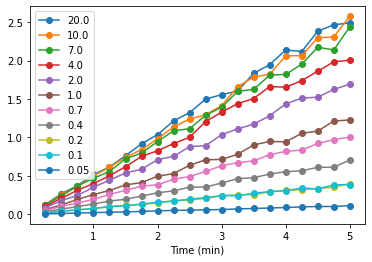

In [6]:
# Inspect the data using the plot command that is available with the dataframe
# We use the plot function that is built into pandas for this simple data display
AP_kin_df.plot(marker = 'o')

In [7]:
# Create a second dataframe with the substrate concentration as the first series.
# Note the syntax for this pandas function - the D and F are capitalized.
MM_df = pd.DataFrame()
MM_df['pNPP (mM)'] = AP_kin_df.columns

## Calculate the Slopes

There is some scatter in the data, but generally, the slopes of the curves increase with increasing substrate concentration. Now we need to calculate the slopes for each of the lines in the plot above. To do so, we can use the linregress function from scipy.stats that we used for the least squares linear regression analysis of the protein assay data from an earlier module. We will use the index from our data frame, `Time (min)`, AP_kin_df. The y values will be taken from each of the series from the same dataframe. 

Remember that linregress provides five outputs: slope, intercept, r-value, p-value and standard error. We need only the slope, so we will use this format

```python
slope, _, _, _, _ = stats.linregress(xdata, ydata)
```

where _ is just a placeholder that we will ignore.

To get the slopes for each series we will use a for loop. First, we'll create an empty list to contain the slopes that are generated as the for loop cycles through the series in the AP_kin_df dataframe.

In [8]:
# Create an empty list to hold the slopes 
slopes = []
# Calculate the slopes from each column in the AP_kin_df dataframe 

for column in AP_kin_df.columns:
    slope, _, _, _, _, = stats.linregress(AP_kin_df.index, AP_kin_df[column])
    slopes.append(slope)
    
# Did we get a list of 11 slopes for each of the 11 series?
slopes

[0.5140907641142858,
 0.5031401632390977,
 0.4704346427639096,
 0.4170212341052633,
 0.34244478125714295,
 0.24625953559097755,
 0.20284295232781954,
 0.1364430576421053,
 0.07644213958496243,
 0.07806979615939849,
 0.022319351245112782]

In [9]:
# Populate the new dataframe with the slopes

MM_df['slopes'] = slopes

# Check the dataframe
MM_df

,pNPP (mM),slopes
0,20.0,0.514091
1,10.0,0.503140
2,7.0,0.470435
3,4.0,0.417021
4,2.0,0.342445
5,1.0,0.246260
6,0.7,0.202843
7,0.4,0.136443
8,0.2,0.076442
9,0.1,0.078070


## Calculate the initial velocity
The initial velocity can be calculated by dividing the slope by the extinction micromlar coefficient under the experimental conditions, 0.015 $\mu$M$^{-1}$cm$^{-1}$. It is possible to complete the calculation and add it to the dataframe with a single line of code.

In [10]:
# Calculate initial velocities and place those in a new column in the dataframe
MM_df['initial velocities'] = MM_df['slopes'] / 0.015
MM_df

,pNPP (mM),slopes,initial velocities
0,20.0,0.514091,34.272718
1,10.0,0.503140,33.542678
2,7.0,0.470435,31.362310
3,4.0,0.417021,27.801416
4,2.0,0.342445,22.829652
5,1.0,0.246260,16.417302
6,0.7,0.202843,13.522863
7,0.4,0.136443,9.096204
8,0.2,0.076442,5.096143
9,0.1,0.078070,5.204653


We will use this dataframe now to perform the nonlinear regression fit using the SciPy library in part 2 of this lesson. To save this data for part 2, so we need to write it to a csv file in our data directory.

In [11]:
outputfile = os.path.join('data', 'MM_data.csv')
MM_df.to_csv(outputfile)

<div class="exercise-this-is-a-title exercise">
<p class="exercise-title">Check your understanding</p>
    <p>You will find an Excel file in your data folder, chymotrypsin_kinetics.xlsx, with some kinetic data from a chymotrypsin experiment. Apply the principles above to create dataframes and a .csv file for creating a Michaelis-Menten plot with these data. Under these assay conditions the extinction coefficient for p-nitrophenol is 18,320 M<sup>-1</sup>cm<sup>-1</sup>.</p>

```{admonition} Hint
:class: dropdown
You will need to get the data into a layout and file format that is easily read by pandas. 
Delete the first seven lines of the Excel file.
Delete the first column of the Excel file.
Save the file as chymotrypsin_kinetics.csv.
Your data will should look something like this: 
![csv image](images/csv_image.png "csv image")
```
    
```{admonition} Solution
:class: dropdown
    
```python
import os 
import pandas as pd 
import numpy as np 
from scipy import stats 
datafile = os.path.join('data', 'chymotrypsin_kinetics.csv') # filehandle created
chymo_rates_df = pd.read_csv(datafile)
chymo_rates_df = chymo_rates_df.set_index('Time (sec)')

def linregress_slope(df_series):
    slope, _, _, _, _, = stats.linregress(df_series.index, df_series.values)
    return slope

chymo_MM_df = pd.DataFrame()
chymo_MM_df['slopes'] = chymo_rates_df.apply(linregress_slope)
chymo_MM_df['Initial Velocities'] = chymo_MM_df['slopes'] / 0.01832
chymo_MM_df.to_csv('biochemist-python/chapters/data/chymo_MM_data.csv')
print(chymo_MM_df)
    
```
The solution is in the next cell. We will remove that cell before we publish the final Jupyter book.
        
</div>


In [12]:
import os 
import pandas as pd 
import numpy as np 
from scipy import stats 
datafile = os.path.join('data', 'chymotrypsin_kinetics.csv') # filehandle created
chymo_rates_df = pd.read_csv(datafile)
chymo_rates_df = chymo_rates_df.set_index('Time (sec)')

def linregress_slope(df_series):
  slope, _, _, _, _, = stats.linregress(df_series.index, df_series.values)
  return slope

chymo_MM_df = pd.DataFrame()
chymo_MM_df['slopes'] = chymo_rates_df.apply(linregress_slope)
chymo_MM_df['Initial Velocities'] = chymo_MM_df['slopes'] / 0.01832 
outputfile = os.path.join('data', 'chymo_MM_data.csv')
chymo_MM_df.to_csv(outputfile)
print(chymo_MM_df)

              slopes  Initial Velocities
1           0.000557            0.030412
0.5         0.000539            0.029437
0.25        0.000500            0.027293
0.125       0.000450            0.024563
0.0625      0.000511            0.027877
0.03125     0.000493            0.026903
0.015625    0.000357            0.019495
0.0078125   0.000229            0.012477
0.00390625  0.000111            0.006043
0.00195313  0.000071            0.003899
